# <font color='blue'> Table Of Contents </font>

### <font color='blue'> Netflix Images Enhanced With AWS Lambda </font>

### <font color='blue'> Benchling: Powering CRISPR with AWS Lambda </font>

### <font color='blue'> iRobot: Serverless IoT </font>

# <font color='blue'> Netflix Images Enhanced With AWS Lambda </font>

**Netflix**, one of the world's largest online media streaming providers, uses **AWS Lambda** to build rule-based self-managing infrastructure. It intends to replace inefficient processes to reduce the rate of errors and save valuable time.

Its strategy revolves around:

* Using event-based triggers to help automate the encoding process of media files 
* Validation of backup completions and instance deployments at scale, and 
* The monitoring of AWS resources used by the organization.

To eliminate technical roadblocks for their studio and business partners, so that artwork content reaches Netflix users, they created **Dynimo** — Netflix’s dynamic image processing service.

Dynimo’s existing architecture is straightforward:

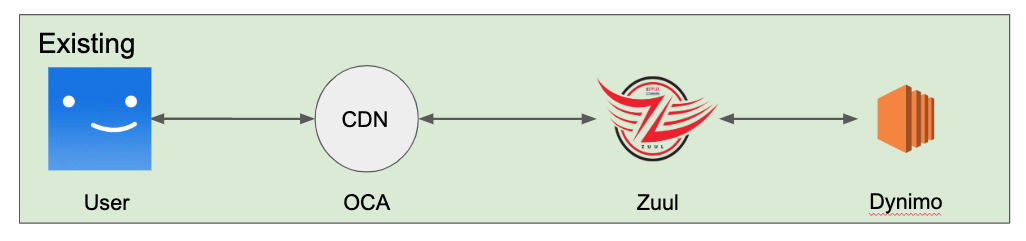

Demand for images is generally serviced by OCA and origin only refreshes cache when it expires. New content and regional failures can happen at any moment. 

Traffic can easily spike 5–10x from its regular base level when this happens. OCA is the first line of defense against these traffic spikes. However without the data OCA must make requests to Dynimo for new content.

Without instances to service these image requests, OCA is left in limbo with no image to return with their request. This sharp demand places a burden on the Dynimo’s infrastructure to scale as OCA fills their cache, in two ways:

* **Metric Delays** — When is there sufficient evidence that scaling is needed?
* **Cold Start Time** — How long until the new instances are able to take traffic?

In practice we see the scaling complete minutes after the spike has occurred. Sometimes it misses the demand spike entirely.

Lambda offers a platform where Demand and Supply(Active Instances) rise and lower together. It also only charges for what is used, making it cost effective.

As part of the transition to Lambda, Dynimo was split into 2 pieces: 

* **Dynimo Preprocessor**: contained the business rules that would be used to generate an image on demand. This ran on EC2. 
* **Dynimo Generator**: did the downloading and processing of images. Generator would run on Lambda.

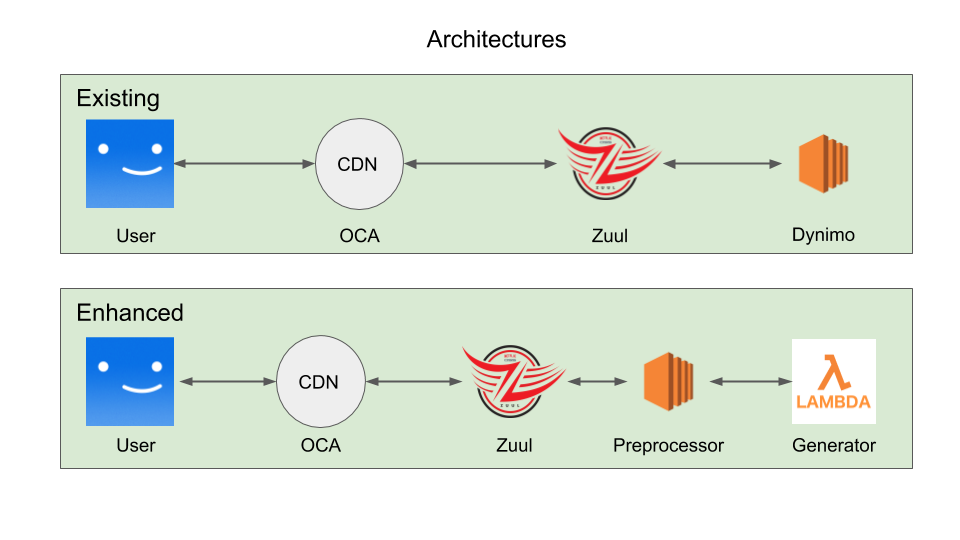

There are clear differences between solution infrastructure deployed on Lambda compared to deployed on EC2:

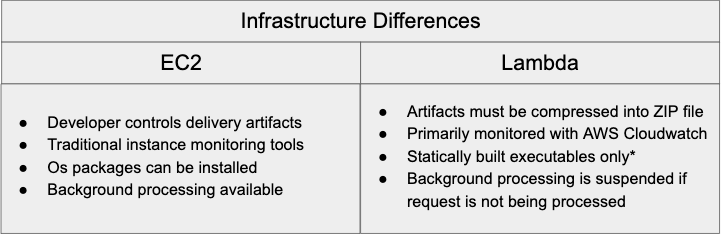

For faster startup times, they rewrote the code base from Java to **golang** - this reduced the Cold Start time.

For the background processing, they removed our background thread clean up and instead did a foreground cleanup before returning the Lambda response.

Here is a measure fo the performance nhancements due to this architecture transition:

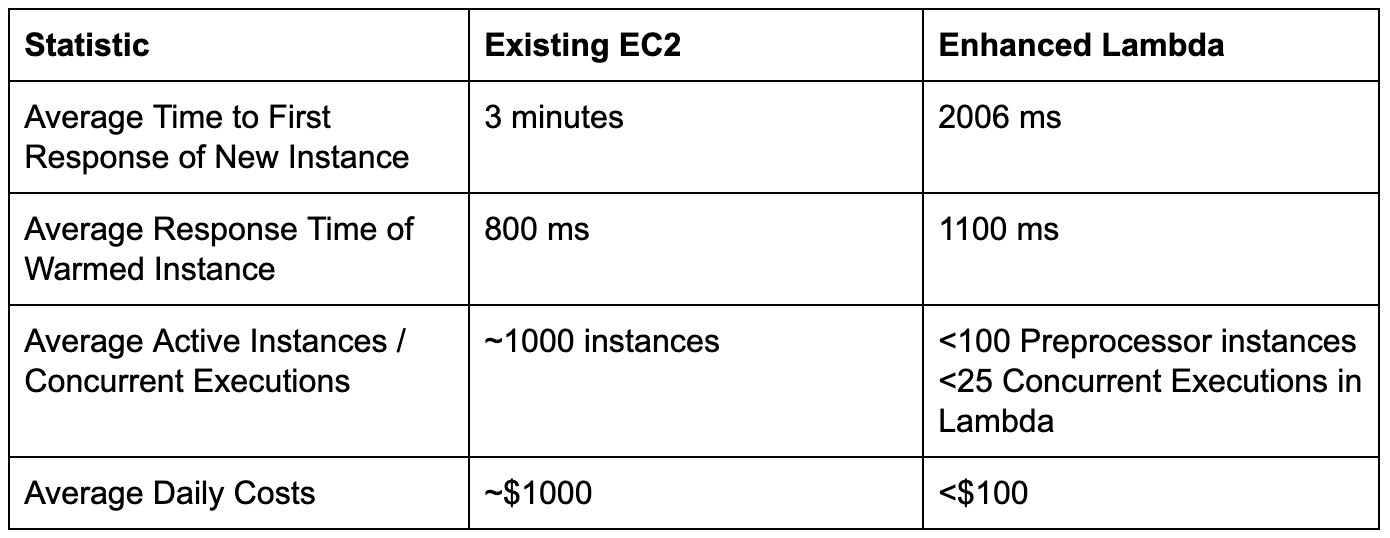

## <font color='blue'> References </font>

1. Netflix and AWS Lambda: Case Study - AWS Solutions - [https://aws.amazon.com/solutions/case-studies/netflix-and-aws-lambda/](https://aws.amazon.com/solutions/case-studies/netflix-and-aws-lambda/)
2. Netflix Images Enhanced With AWS Lambda: Medium - [https://netflixtechblog.medium.com/netflix-images-enhanced-with-aws-lambda-9eda989249bf](https://netflixtechblog.medium.com/netflix-images-enhanced-with-aws-lambda-9eda989249bf)
3. Image: Existing Netflix Dynimo Architecture - [https://miro.medium.com/max/2400/0*yPAfD2Otb6Qiqw9V](https://miro.medium.com/max/2400/0*yPAfD2Otb6Qiqw9V)
4. Image: Netflix Dynimo Architecture With Lambda - Two Parts - [https://miro.medium.com/max/2400/0*0HDhcgjNXFrlnkIb](https://miro.medium.com/max/2400/0*0HDhcgjNXFrlnkIb)
5. Image: Netflix Dynimo Architecture With Lambda: - Lambda v/s EC2 - [https://miro.medium.com/max/2400/0*hDcYvIJtkncW2YlV](https://miro.medium.com/max/2400/0*hDcYvIJtkncW2YlV)
6. Image: Netflix Dynimo Architecture With Lambda - enhanced Performance - [https://miro.medium.com/max/2400/1*3F3UcHdHjsiLdI3m4SZalw.png](https://miro.medium.com/max/2400/1*3F3UcHdHjsiLdI3m4SZalw.png)

# <font color='blue'> Benchling: Powering CRISPR with AWS Lambda </font>

**Benchling** is a San Francisco–based life science software company that provides a complete R&D software platform. The system:

* Makes it easy for scientists to design, organize, and share their experiments from start to finish 
* Offers a suite of workflow management, and
* Offers molecular biology design and analysis tools to support its aims.

## <font color='blue'> The Benchling CRISPR Algorithm: Many Facets </font>

**CRISPR** is a genome-editing technique that has rapidly gained popularity in the world of synthetic biology over the last two years. Scientists are already applying CRISPR towards curing genetic disorders, creating disease models, accelerating drug development, and more. 

The Benchling CRISPR Solution - the **CRISPR CAS9 Genome Editing Algorithm** - works with the following constraints posed by the genome editing problem:

* They have the genome in advance. Each species has only one or two reference genomes that scientists use.
* DNA strings are made up of only 4 different characters (A, C, G, and T).
* The length of a guide is 20 bases.
* The maximum edit distance (replaces only) is 4.


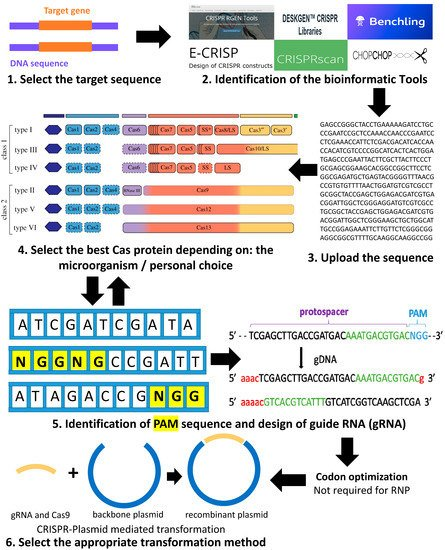
A few solutions offer themselves here:

* **Indexing the Genome**: Create a hash_table that maps every 20 character string in the genome to the list of locations that it occurs. 
    * The table is too large to store in memory, and each lookup is a disk seek.
* **Preprocess Everything**: Store the matches for every possible guide — essentially, a full map from all possible inputs to their corresponding answer. That way, given a guide, a single query can be dpne into the hash table to find all of its matches.
    * This would result in a huge storage requirement 
* **Hash Set For Guides**: Create a hash set possible_matches with an entry for every possible match, for each guide. Then, simply iterate over the genome, and check at every index if a corresponding hash set entry exists.
    * Checking existence in a hash set requires computing the hash dynamically, multiple times, for each iteration over the genome.
    
There are other solutions too. The summary of these attempts is that the storage and compute requirements are really mind-boggling!

## <font color='blue'> Infrastructure Constraints And Features </font>

The goal is to enable this search across dozens of genomes in a way that’s fast, cheap, and dynamic (it should be easy to add new genomes). 

Since the CRISPR CAS9 Algorithm doesn’t require any indexing or preprocessing of the genome, thr system needs to support genomes that users upload.


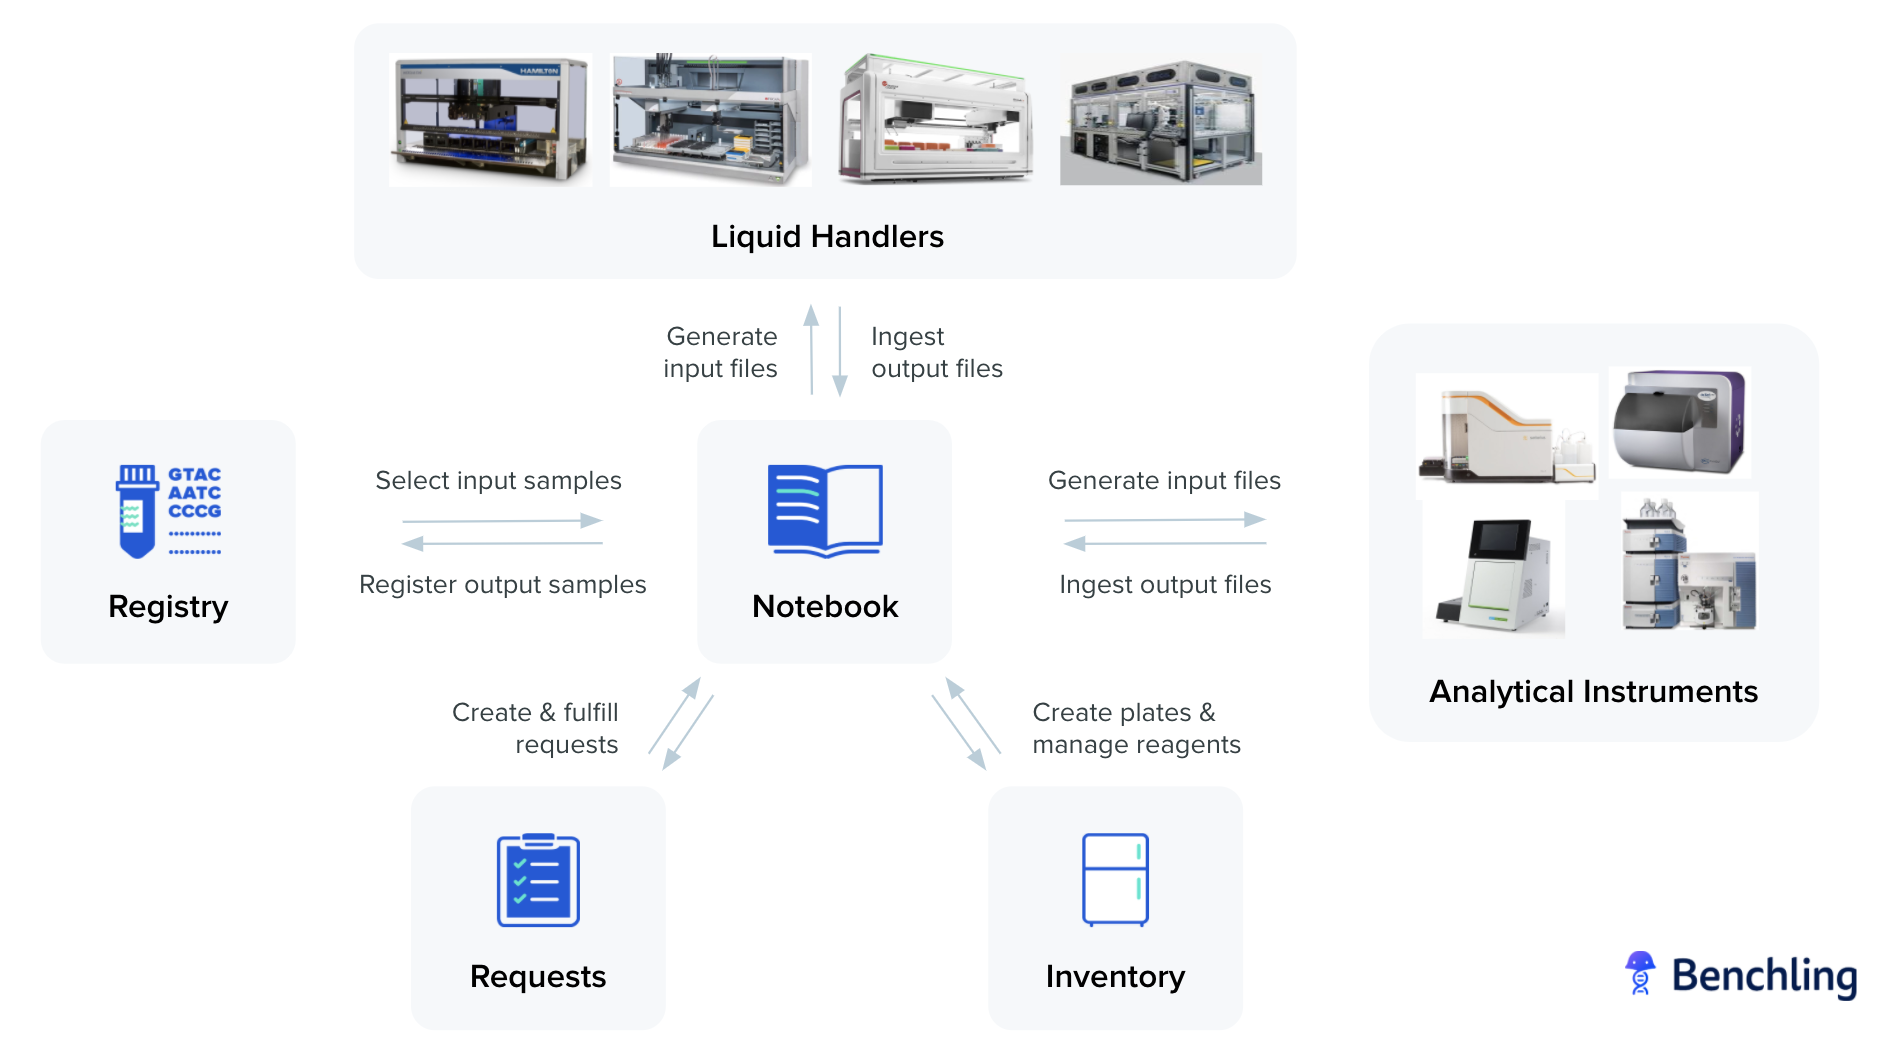
Here are the basic infrastructure challenges Benchling needs to face:

* A few hundred thousand CRISPR searches are run every month, in bursts.
* The speed should not depend on how many concurrent searches are running.
* Currently have 30 genomes, each 3GB in size; we should be able to support an arbitrary number of genomes.
* An algorithm (implemented in C++) that takes in a string of DNA and list of queries, which runs at about 1 second per 100MB.
* To reduce complexity, we’d like this to run easily in our current AWS architecture.

The features this architecture needs to support include:

* **Dynamic Server Allocation**: Serve requests quickly even at peak times, and it would cost too much to allocate for the maximum load.
* **Shared File System**: Or, separate servers per genome

## <font color='blue'> Solution: AWS Lambda Infrastructure </font>

**AWS Lambda** provides all of the infrastructure around dynamic server allocation. 

* You upload a ZIP file with the code you need to run, and specify the entry point for the request. 
* For any request, Lambda will run the code, creating new servers if necessary. 
* You pay for the amount of time used and memory allocated for each request. 

Benchling uses Lambda to offload long-running and parallelizable work from our web servers.

Our goal is to split up a CRISPR search across several Lambda “tasks” to reduce costs and increase scalability. The CRISPR search problem is easily parallelized by splitting the genome into smaller regions that can be processed separately. 


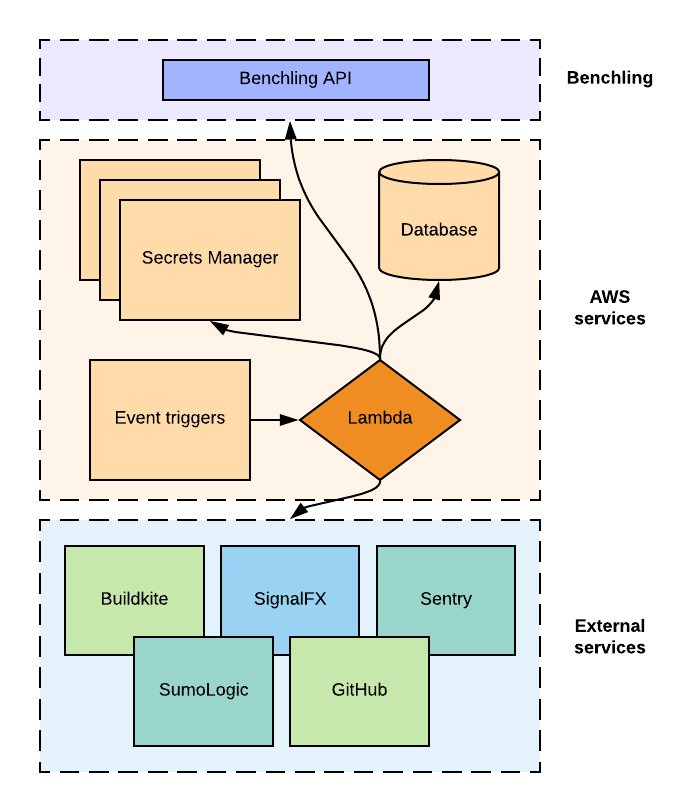

The general approach is fairly straightforward:
* A web server receives a request to do a CRISPR search on a specific genome.
* The web server splits up the genome into smaller regions.
* The web server invokes the Lambda function for each region.
* Once all of the Lambda tasks complete, the results are combined and returned to the user.

This approach completely solves the dynamic scaling issue. There is no need to maintain several servers to perform searches, as AWS handles all the allocations.


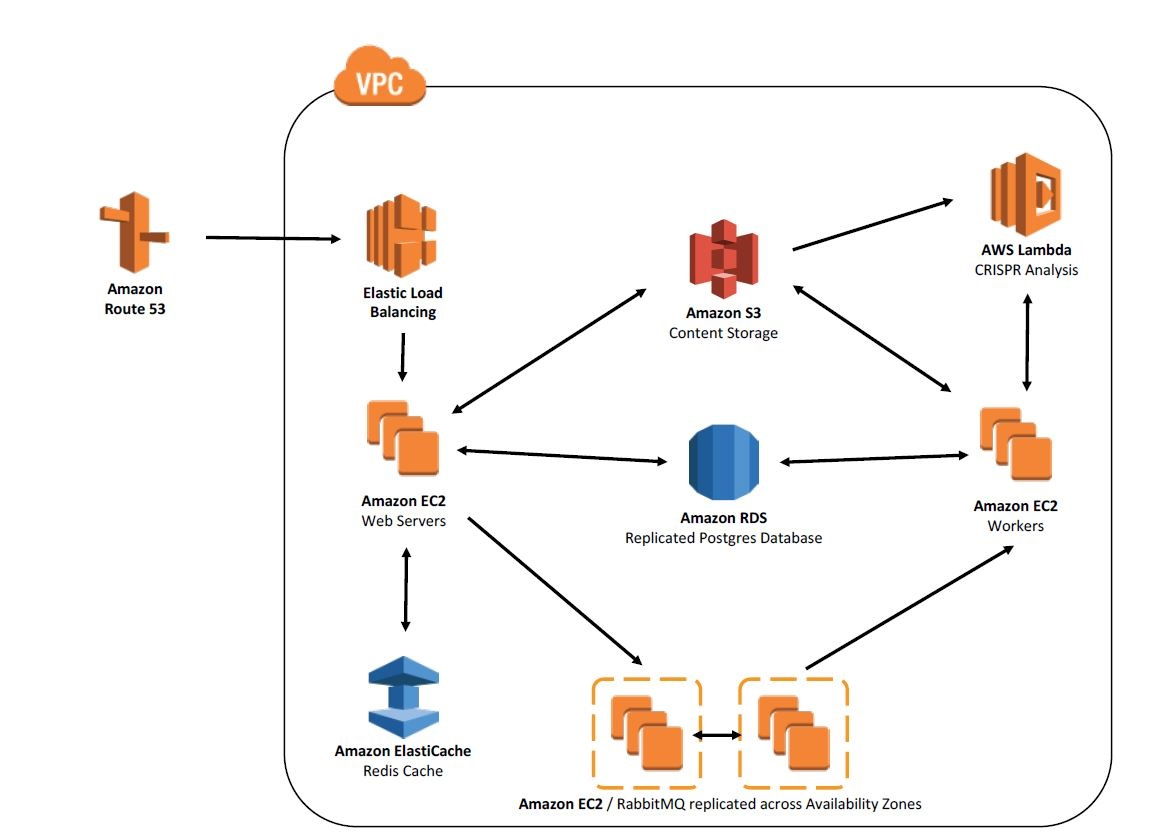

## <font color='blue'> Implementation Issues </font>

* Lambda only supports Javascript (Node.js) and Java. Running C++ code is accomplished using NodeJS Add-ons. Besides, AWS Lambda only runs on Amazon Linux, so the build needs to happen there.
* The Lambda function needed to easily access regions of the 3GB genome. Amazon has several size limitations that makes this hard. To solve this, one can download the genome region from S3 on each Lambda invocation

## <font color='blue'> Analysis </font>

* **Speed**: The new Lambda infrastructure can theoretically run at arbitrary speeds, since the amount of parallelization can be configured.
* **Scalability**: The AWS Lambda infrastructure scales perfectly with demand.
* **Cost**: Using the Lambda infrastructure, one pays for the number of Lambda invocations, the total duration of the requests, and the number of S3 requests. This comes out to USD 60 per month, for hundreds of thousands of CRISPR searches.
* **Dynamic User Uploads**: Since the genome is only stored in one place. It is possible to support user-specified genomes by uploading them directly to S3.

## <font color='blue'> References </font>

1. Benchling Case Study: AWS Solutions - [https://aws.amazon.com/solutions/case-studies/benchling/](https://aws.amazon.com/solutions/case-studies/benchling/)
2. Optimizing CRISPR: Sub-Second Searches On A 3 Billion Base genome - Benchling Engineering - [https://benchling.engineering/optimizing-crispr-sub-second-searches-on-a-3-billion-base-genome-f1d319081bbf](https://benchling.engineering/optimizing-crispr-sub-second-searches-on-a-3-billion-base-genome-f1d319081bbf)
3. Powering CRISPR With AWS Lambda: Benchling Engineering - [https://benchling.engineering/powering-crispr-with-aws-lambda-f22c151a1ffc](https://benchling.engineering/powering-crispr-with-aws-lambda-f22c151a1ffc)
4. Image: Benchling CRISPR CAS9 Algorithm - [https://www.mdpi.com/life/life-10-00295/article_deploy/html/images/life-10-00295-g001-550.jpg](https://www.mdpi.com/life/life-10-00295/article_deploy/html/images/life-10-00295-g001-550.jpg)
5. Image: Benchling CRISPR AWS Infrastructure - [https://d1.awsstatic.com/case-studies/Benchling_architecture.945030da5d79e92d3d4da65a9c3ffb5af4fdbc79.jpg](https://d1.awsstatic.com/case-studies/Benchling_architecture.945030da5d79e92d3d4da65a9c3ffb5af4fdbc79.jpg)
6. Image: Benchling Engineering Challenges - [https://miro.medium.com/max/3764/1*N1URCKkjY8yHtxhBOM5uFw.png](https://miro.medium.com/max/3764/1*N1URCKkjY8yHtxhBOM5uFw.png)
7. Image: Benchling - Where AWS Lambda Fits - [https://miro.medium.com/max/1400/1*Zund_zUfS7I3uSpL24b5dA.png](https://miro.medium.com/max/1400/1*Zund_zUfS7I3uSpL24b5dA.png)

# <font color='blue'> iRobot: Serverless IoT </font>

**iRobot**, a leading global consumer robot company, designs and builds robots that empower people to do more both inside and outside the home. iRobot created the home-cleaning robot category with the introduction of its **Roomba Vacuuming Robot** in 2002.

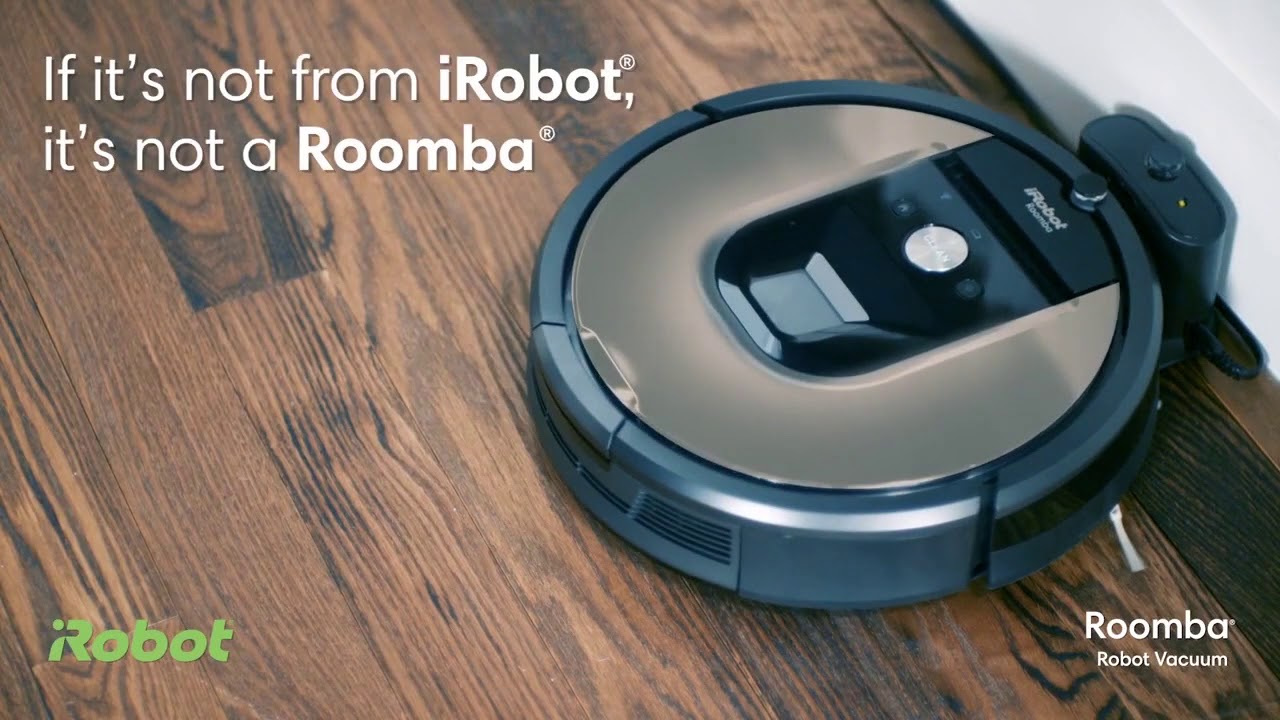

To run the web applications that connect to the new Wi-Fi-connected Roomba vacuums, iRobot is using about 25 AWS services. 

At the core of the iRobot platform are **AWS Lambda** and the **AWS IoT Platform**.

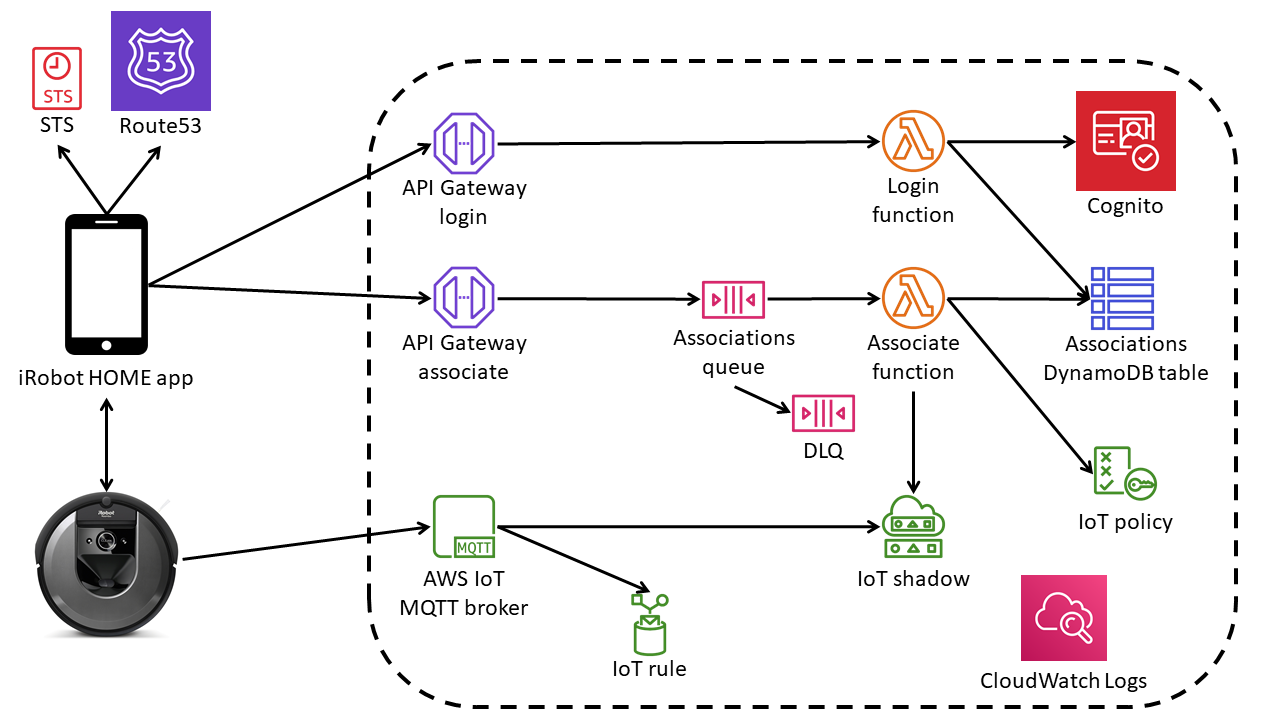


AWS IoT, which can process trillions of messages between billions of devices and AWS or other endpoints, provides the connectivity layer between the robots and the iRobot cloud platform. 

AWS Lambda runs code in response to events to provide function-based compute services for the serverless backend that powers the iRobot cloud application. 

The solution also uses **Amazon Kinesis**, which ingests real-time data streams from robots, and the **Amazon API Gateway**, which can publish APIs and secure them at any scale.

By using a **serverless architecture** based on AWS IoT and AWS Lambda, iRobot is able to keep the cost of the cloud platform low, avoid the need for subscription services, and manage the solution with fewer than 10 people. 

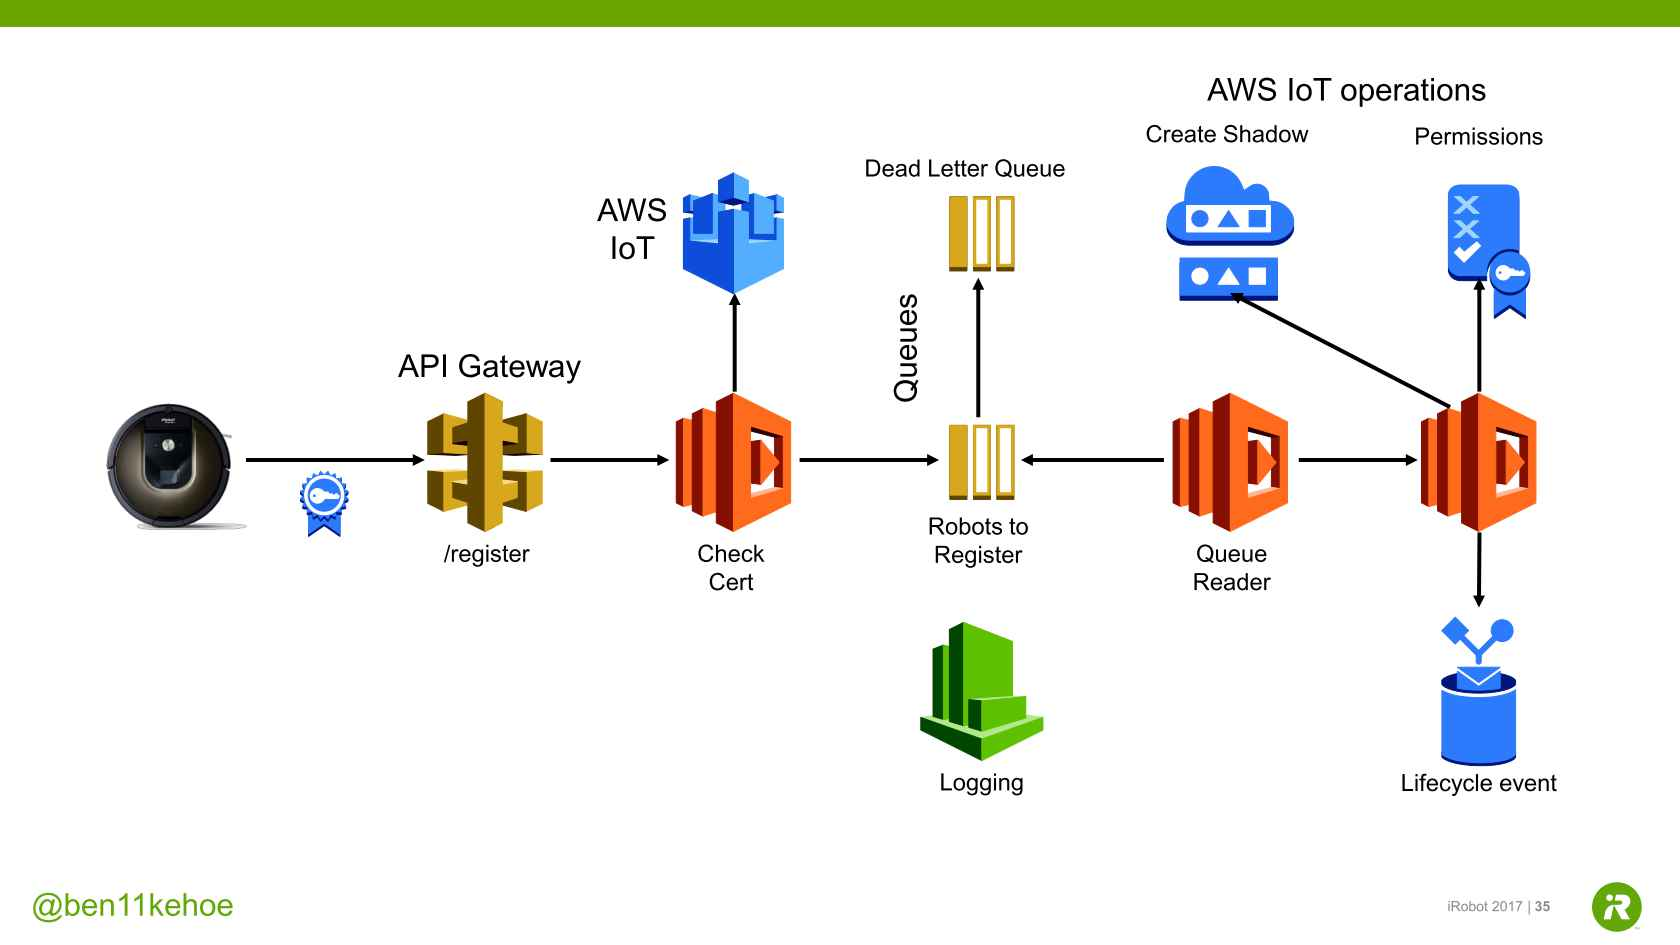


iRobot’s Roomba 900 Series vacuum cleaners, for example, use **visual simultaneous localization and mapping (vSLAM)** technology to navigate an entire level of a home. It builds a map of the home, and it is this map that could provide the foundational information needed to help a smart home understand itself and enable truly seamless, autonomous home automation.

## <font color='blue'> References </font>

1. iRobot Case Study: AWS Solutions - [https://aws.amazon.com/solutions/case-studies/irobot/](https://aws.amazon.com/solutions/case-studies/irobot/)
2. Image: iRobot Roomba 976 Series Vacuum Cleaner - [https://i.ytimg.com/vi/vNuko3yc0UM/maxresdefault.jpg](https://i.ytimg.com/vi/vNuko3yc0UM/maxresdefault.jpg)
3. Image: iRobot Roomba AWS Infrastructure: 01 - [https://d1.awsstatic.com/architecture-diagrams/associate-robot-diagram.3b0d8d332e2de0005d17eb6a2e8241a5fdfbde4b.png](https://d1.awsstatic.com/architecture-diagrams/associate-robot-diagram.3b0d8d332e2de0005d17eb6a2e8241a5fdfbde4b.png)
4. Image: iRobot Serverless IoT - [https://res.infoq.com/presentations/serverless-iot-irobot/en/slides/sl35-1522414286158.jpg](https://res.infoq.com/presentations/serverless-iot-irobot/en/slides/sl35-1522414286158.jpg)